# BBC 文本分类和模型比较

**摘要：**我们使用 BBC 数据集进行文本分类。在文本预处理阶段，我们尝试使用词编码和词向量的方式，在训练阶段，我们构建了 DNN、LSTM、BERT 等多个深度学习模型进行训练，并进行了模型比较，最高达到了 99% 的准确率。最后，为了进一步实现在超大文本集上进行训练，我们使用基于 Spark 的分布式算法在集群服务器上进行训练测试。



| 模型         | 计算配置 | 用时 | 准确率 | 可拓展性 |
| ----------- | ----------- | ------ | ------ | --- |
| Word2Vec + LSTM  |阿里云服务器 Xeon 8 核 CPU 32G 内存| 30 分钟 | 80% | 低-单机 |
| tokenize + DNN  |阿里云服务器 Xeon 8 核 CPU 32G 内存| 1  分钟 | 97% | 低-单机 |
| bert - 小型       |阿里云服务器 Xeon 8 核 CPU 32G 内存| 10  分钟 | 97% | 低-单机 |
| bert - AL        |阿里云服务器 Xeon 8 核 CPU 32G 内存| 15  分钟 | 98% | 低-单机 |
| bert - 标准      |阿里云服务器 Xeon 8 核 CPU 32G 内存| 30  分钟 | **99%** | 低-单机 |
| spark - 回归 - 网格搜索调参  |中央财经大学大数据高性能分布式集群 | 5 分钟 | 96% | 高-集群 |
| spark - 决策树 - 网格搜索调参  |中央财经大学大数据高性能分布式集群 | 20 分钟 | 97% | 高-集群 |
|spark - 梯度助推树 - 网格搜索调参|中央财经大学大数据高性能分布式集群 | 15 分钟 | 98% | 高-集群 |
| spark - 随机森林 - 网格搜索调参 |中央财经大学大数据高性能分布式集群 | 30 分钟 | 97% | 高-集群 |


> 分布式模型在该小型数据集上没有优势，进行此项的意义在于对大型文本数据集可拓展性的技术储备，仅有在文本量级超过单机可承载上限时，分布式计算才具备意义

> 注意：请勿在低配置计算机上运行该笔记本

## 环境安装及设置

请预先安装以下模块：

- tensorflow (2.0以上版本）
- tensorflow-text（用于文字预处理）
- tf-models-official

In [1]:
import os
import pydot
import shutil
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from official.nlp import optimization
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

2022-01-11 23:38:51.631323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-11 23:38:51.631382: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 数据处理

### 标签处理

我们将分类列由类别名称转为数字

In [2]:
# ------------------> 加载数据
dat = pd.read_csv('./data/bbc-text.csv')

# ------------------> 标签处理
encoder = LabelEncoder()
encoder.fit(dat['category'])
y = encoder.transform(dat['category'])
text_labels = encoder.classes_
text_labels

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

### 数据集划分

划分 20% 的测试集，再从训练集中划分 20% 的验证集



In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dat['text'], y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)

### 数据集格式转换

我们将数据集转换为 `tf.data.Dataset` 的格式，使用自动的缓冲区大小，使用 32 的 `batch size`

* batch size 为一次训练所抓取的数据样本数量，其大小与模型的收敛速度和随机梯度噪音有关。
* 分批训练相对于直接对全训练集训练的好处在于：提高了每次迭代的训练速度、利于多线程训练、使得梯度下降的方向更加准确
* batch size 的大小与模型的收敛速度和随机梯度噪音有关
* 当 batch size 过小时，在一定的迭代次数下，模型来不及收敛
* 当 batch size 过大时，一方面容易出现内存紧缺，另一方面模型的泛化能力会变差

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test))

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

2022-01-11 23:38:55.365829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 23:38:55.365880: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 23:38:55.365916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nlp): /proc/driver/nvidia/version does not exist
2022-01-11 23:38:55.366350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


我们对数据集进行预览

In [5]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(2):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({text_labels[label]})')

Review: b'itunes now selling band aid song ipod owners can now download the band aid single from itunes after apple reached agreement with the charity.  apple had been unwilling to raise the cost of the single in line with other download services  said band aid. but the single is now on sale for 79p - the usual cost of a song from itunes - with apple donating a further 70p to the charity for each song downloaded. a copy of the original 1984 song is also available for download at 79p - with all proceeds going to the charity.  more than 72 000 copies of the new band aid single were sold on its first day of release on monday  according to sales figures. the track has become the fastest-selling single of the year so far  shifting more copies than the rest of the top 30 combined  hmv claimed. dido  robbie williams and chris martin are among those featured on the new version of do they know it s christmas   which is raising money to fight hunger in africa. if the track sold 500 000 copies  m

2022-01-11 23:38:55.406115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Word2Vec + LSTM

## 文本预处理

我们建立词字典进行词编码，字典的大小限制在 1000 词

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'for', 's', 'is',
       'that', 'it', 'on', 'said', 'was', 'he', 'be', 'with', 'has'],
      dtype='<U13')

编码的长度由所有文本中最长的文本决定

In [7]:
encoded_example = encoder(text_batch)[:3].numpy()
encoded_example

array([[  1,  75,   1, ...,   0,   0,   0],
       [477,   1,   1, ...,   0,   0,   0],
       [322, 332,   1, ...,   0,   0,   0]])

打印示例：

## 模型结构

1. 第一层为 `Embedding` 层，我们使用 `word2vec` 方法将单词编码转换为词向量。这些词向量经过训练，对于意思相近的词，其向量夹角小。
2. 第二层使用双向的长短期记忆层。长短期记忆网络层是一种特殊的循环神经网络层，它能够减轻长序列训练过程中的梯度消失和梯度爆炸问题，适合此处词向量长度较长的情况。它遍历序列中的每个元素作为输入，按照时间顺序传递输出。由于我们使用双向结构，最终结果由输入的前向和后向传递共同决定，这使得最前端的输入不必通过漫长的处理步数才能影响到最终结果，有效的提高了训练在文本中的均匀度。
3. 第三层为全连接层，由于在多层神经网络中梯度容易在深层网络中变得极小，使得参数无法正常更新，所以我们使用 `RELU` 作为激活函数解决梯度消失问题。
4. 第四层为输出维度为 5 的输出层，为了得到多分类的概率值，使用 `softmax` 函数将输出值压缩至 0 - 1 的范围内。

In [8]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax', name='classifier')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.summary()

In [10]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 训练模型

In [11]:
history = model.fit(train_ds, epochs=30,
                    validation_data=val_ds,
                    validation_steps=30)

Epoch 1/30
45/45 [==============================] - 51s 986ms/step - loss: 1.6084 - accuracy: 0.1826 - val_loss: 1.6053 - val_accuracy: 0.2247
Epoch 2/30
45/45 [==============================] - 39s 877ms/step - loss: 1.6039 - accuracy: 0.2949
Epoch 3/30
45/45 [==============================] - 37s 829ms/step - loss: 1.5967 - accuracy: 0.3357
Epoch 4/30
45/45 [==============================] - 37s 819ms/step - loss: 1.5773 - accuracy: 0.3055
Epoch 5/30
45/45 [==============================] - 35s 793ms/step - loss: 1.5295 - accuracy: 0.4417
Epoch 6/30
45/45 [==============================] - 36s 808ms/step - loss: 1.4455 - accuracy: 0.4621
Epoch 7/30
45/45 [==============================] - 37s 823ms/step - loss: 1.2456 - accuracy: 0.4684
Epoch 8/30
45/45 [==============================] - 40s 891ms/step - loss: 1.1147 - accuracy: 0.4965
Epoch 9/30
45/45 [==============================] - 40s 888ms/step - loss: 1.0414 - accuracy: 0.5147
Epoch 10/30
45/45 [==============================

(0.0, 1.6601696819067002)

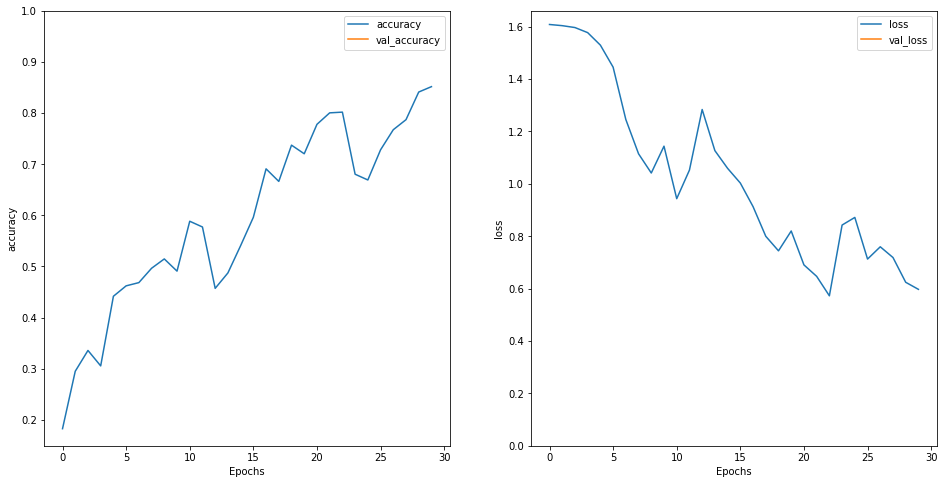

In [12]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## 模型评价

In [13]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

14/14 [==============================] - 2s 124ms/step - loss: 0.6922 - accuracy: 0.7528
Test Loss: 0.6922494173049927
Test Accuracy: 0.7528089880943298


# Tokenize + DNN + 防止过拟合

## 文本预处理

In [14]:
max_words = 1000
tokenize = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)
tokenize.fit_on_texts(X_train) # fit tokenizer to our training text data
x_train_token = tokenize.texts_to_matrix(X_train)
x_test_token = tokenize.texts_to_matrix(X_test)
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train_token = tf.keras.utils.to_categorical(y_train, 5)
y_test_token = tf.keras.utils.to_categorical(y_test, 5)
print('x_train shape:', x_train_token.shape)
print('x_test shape:', x_test_token.shape)
print('y_train shape:', y_train_token.shape)
print('y_test shape:', y_test_token.shape)

x_train shape: (1424, 1000)
x_test shape: (445, 1000)
y_train shape: (1424, 5)
y_test shape: (445, 5)


## 模型结构

经过多次调参，我们发现增大全连接层输出的维度能有效提升准确率。

为了减轻训练过程中的过拟合现象，我们使用 dropout 方法来增强神经元的协同适应能力。我们在输入层和中间层分别加入 50% dropout ，即每个神经元有 50% 的概率被随机剔除。由于输出层是我们所需的结果，不使用 dropout 方法。

In [15]:
batch_size = 32
epochs = 10 
drop_ratio = 0.5


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(max_words,)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(drop_ratio))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(drop_ratio))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

## 训练模型

正常情况下，随着训练迭代次数的增加，损失函数逐渐减小，对训练集的拟合越来越趋向于精细。然而过度精细的拟合容易导致模型的泛化能力变差，即当模型用于之前未曾训练过的数据时表现很差。为了观测这种情况，我们需要划分一部分数据与用于训练的数据隔开，这便是我们划分验证集的原因之一。

为了防止模型过拟合，我们设定在验证集准确率连续三次迭代不再上升时提前终止训练。

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x_train_token, y_train_token,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[callback],
                    validation_split=0.1)

Epoch 1/10
41/41 [==============================] - 1s 7ms/step - loss: 0.9210 - accuracy: 0.6550 - val_loss: 0.1990 - val_accuracy: 0.9441
Epoch 2/10
41/41 [==============================] - 0s 4ms/step - loss: 0.2046 - accuracy: 0.9329 - val_loss: 0.1247 - val_accuracy: 0.9580
Epoch 3/10
41/41 [==============================] - 0s 4ms/step - loss: 0.0998 - accuracy: 0.9711 - val_loss: 0.0962 - val_accuracy: 0.9650
Epoch 4/10
41/41 [==============================] - 0s 4ms/step - loss: 0.0424 - accuracy: 0.9875 - val_loss: 0.0827 - val_accuracy: 0.9790
Epoch 5/10
41/41 [==============================] - 0s 4ms/step - loss: 0.0221 - accuracy: 0.9977 - val_loss: 0.0715 - val_accuracy: 0.9790
Epoch 6/10
41/41 [==============================] - 0s 4ms/step - loss: 0.0195 - accuracy: 0.9961 - val_loss: 0.0850 - val_accuracy: 0.9860
Epoch 7/10
41/41 [==============================] - 0s 4ms/step - loss: 0.0136 - accuracy: 0.9969 - val_loss: 0.0981 - val_accuracy: 0.9720
Epoch 8/10
41/41 [==

## 模型评价

In [18]:
score = model.evaluate(x_test_token, y_test_token,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9775
Test loss: 0.06777272373437881
Test accuracy: 0.9775280952453613


# BERT

## BERT 简介

BERT 是一系列双向文字编码转换模型的总称，用来结合上下文语义计算每个词的词向量，在自然语言处理中被广泛使用。

我们使用了前人在超大型语料库上训练的已有基础 BERT 模型，通过迁移学习的方式在我们的 BBC 文本数据集上进行微调。


## 加载预训练 BERT 模型

我们首先使用了一个参数量较少的 small-BERT 模型用于测试，在通过测试后，为了进一步提升模型的准确度，我们使用 al-BERT 进行正式训练。

> 在该笔记本中，我们仅展示 small-BERT 版本

In [19]:
tfhub_handle_encoder = 'https://storage.googleapis.com/tfhub-modules/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1.tar.gz'
tfhub_handle_preprocess = 'https://storage.googleapis.com/tfhub-modules/tensorflow/bert_en_uncased_preprocess/3.tar.gz'

## 预处理模型

在 BERT 的输入层，对于原始的文字输入，我们需要将其转换成为数值编码。每一个 BERT 模型都有其严格对应的预处理模型来提升转换效果。

我们展示该预处理模型的输出结果，可以看到该预处理模型将输入的向量设为 128 的长度。

In [20]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['The first sentence. The second sentence.']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 1996 2034 6251 1012 1996 2117 6251 1012  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## BERT 模型

在进行迁移学习之前，我们先看预训练 BERT 模型的输出格式

In [21]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9992781   0.31525105 -0.25964963  0.55944437  0.00783995  0.9791419
  0.9977204  -0.9327053  -0.84368324 -0.98138165 -0.4435     -0.9903451 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.4488559  -0.5851824  -0.6790177  ... -1.764277   -0.45622617
   0.35492766]
 [ 0.24628739  0.08727125 -1.2822778  ... -2.0664744  -0.27477688
  -0.2544793 ]
 [ 0.43256244  0.5654976  -0.79072297 ... -0.65594614 -0.22825454
  -0.04055907]
 ...
 [ 1.1035298  -0.97563946  0.19795775 ... -1.2058376   0.00869213
   0.69881415]
 [ 0.25988367 -0.39930332 -0.49941957 ... -1.1005459  -0.14869173
   0.27366376]
 [ 0.18883078 -0.47520044 -0.4314221  ... -1.1670263  -0.05709446
   0.17906033]]


## 迁移学习

In [22]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

在开始训练之前，我们测试模型搭建过程是否有误。

In [23]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.50154585 0.5305265  0.589105   0.5593288  0.56779325]], shape=(1, 5), dtype=float32)


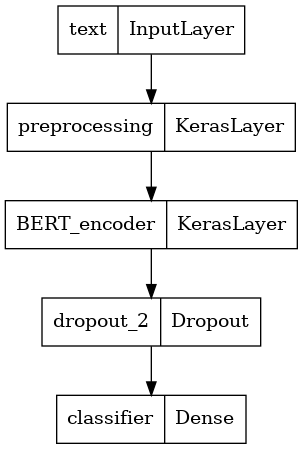

In [24]:
tf.keras.utils.plot_model(classifier_model)

In [25]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## 训练模型

### 损失函数

我们使用交叉熵作为我们的损失函数：

$$ -\sum_{c=1}^My_{o,c}\log(p_{o,c}) $$

其中：

- M 是分类数
- y 是标签 c 在观测 o 下是否分类正确的 0/1 变量
- p 是预测概率

In [26]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

### 学习率

由于神经网络刚开始训练时非常不稳定，因此刚开始的学习率应当设置得很低很低，这样可以保证网络能够具有良好的收敛性。但是较低的学习率会使得训练过程变得非常缓慢，因此这里采用从较低学习率逐渐增大至较高学习率的方式实现网络训练前 10% 次迭代的“热身”阶段。一直使用较高学习率是不合适的，因为它会使得权重的梯度一直来回震荡，很难使训练的损失值达到全局最低谷。因此在 warm-up 结束后，我们使用线性减小的学习率。

In [27]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

### 优化器

在迁移学习时，我们选取的优化器与 BERT 在预训练时的 `Adamw` 优化器保持一致。

<img src="./figure/Adamw.png" alt="Drawing" style="width: 400px;"/>

Adam 的超收敛性质使其在训练学习率高的神经网络时可以达到节省迭代次数的效果。只要调整得当，Adam 在实践上都能达到 SGD+Momentum 的高准确率，而且速度更快。在几年前人们普遍认为 Adam 的泛化性能不如 SGD+Momentum，然而今年论文表明这通常是由于所选择的超参数不正确导致，通常来说 Adam 需要的正则化比 SGD 更多。

In [28]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### 开始训练

In [29]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print('----- 训练开始 -----')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)
print('----- 训练完成 -----')

----- 训练开始 -----
Epoch 1/5
45/45 [==============================] - 75s 2s/step - loss: 1.2007 - sparse_categorical_accuracy: 0.5625 - val_loss: 0.2956 - val_sparse_categorical_accuracy: 0.9326
Epoch 2/5
45/45 [==============================] - 72s 2s/step - loss: 0.1909 - sparse_categorical_accuracy: 0.9445 - val_loss: 0.1289 - val_sparse_categorical_accuracy: 0.9691
Epoch 3/5
45/45 [==============================] - 72s 2s/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.1150 - val_sparse_categorical_accuracy: 0.9747
Epoch 4/5
45/45 [==============================] - 69s 2s/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.1175 - val_sparse_categorical_accuracy: 0.9747
Epoch 5/5
45/45 [==============================] - 68s 2s/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.1269 - val_sparse_categorical_accuracy: 0.9607
----- 训练完成 -----


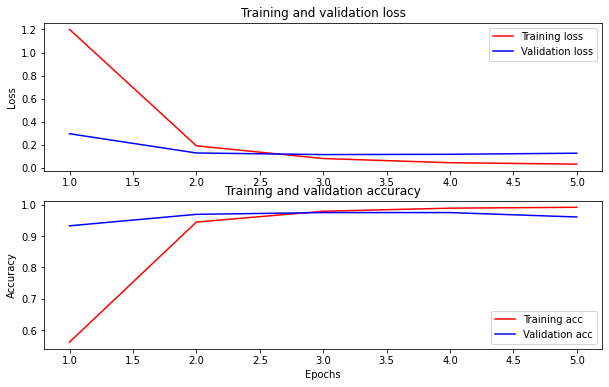

In [30]:
history_dict = history.history

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 模型评价

我们在测试集上计算分类准确率

In [31]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

14/14 [==============================] - 5s 370ms/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9820
Loss: 0.05666141211986542
Accuracy: 0.9820224642753601


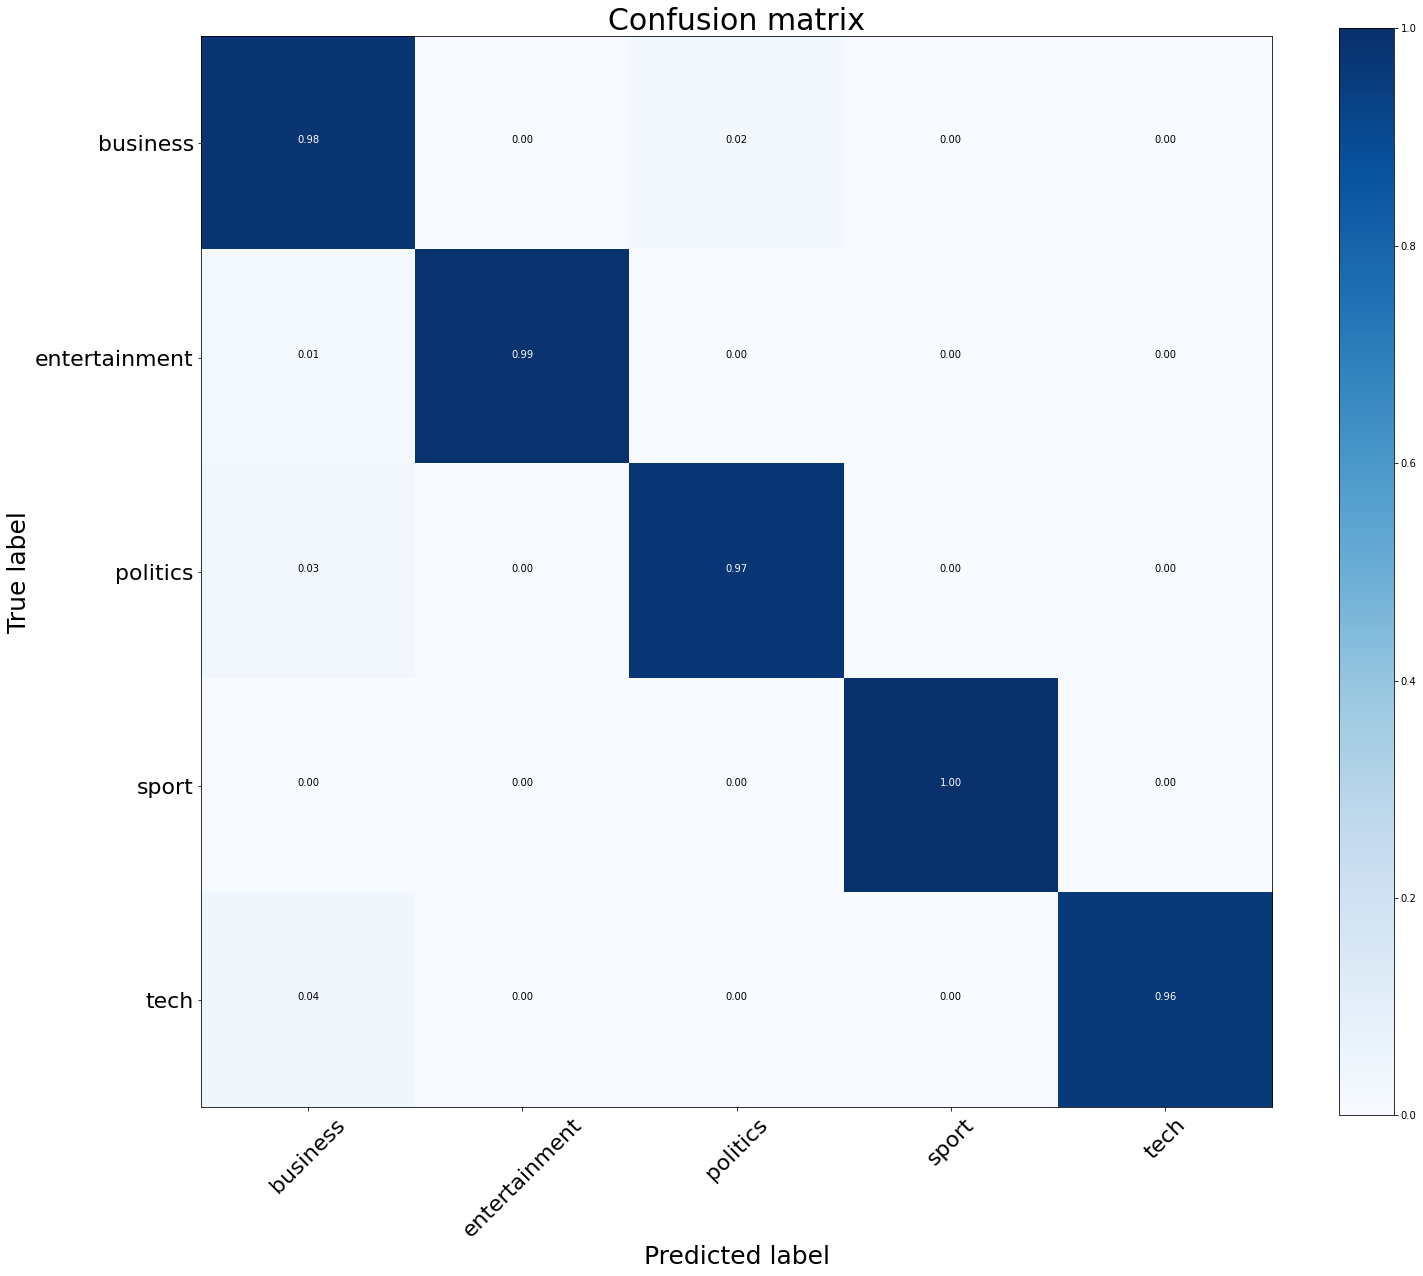

In [32]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    
predict_probability = classifier_model.predict(test_ds)
prediction = [np.argmax(i) for i in predict_probability]
cnf_matrix = confusion_matrix(y_test.tolist(), prediction)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## 模型应用

我们将经过训练完成的模型保存，方便调用。

In [33]:
classifier_model.save('./model/bbc_bert', include_optimizer=False)

2022-01-12 00:04:42.660889: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


使用模型对输入的文本进行分类。

我们输入一则测试新闻文本：“如何在股票市场投资”，该文本被模型分类为商业，符合预期。

In [34]:
model = tf.saved_model.load('./model/bbc_bert')
query = ['how to invest in the stock market']
result = tf.sigmoid(model(tf.constant(query)))
print('----- 每种分类的得分 -----')
dict(zip(text_labels, result.numpy()[0]))

----- 每种分类的得分 -----


{'business': 0.6644883,
 'entertainment': 0.5076837,
 'politics': 0.50357664,
 'sport': 0.5106461,
 'tech': 0.5570022}

# 分布式训练

> 在该笔记本中，我们演示的为并非真实的分布式，而是单机模拟的伪分布式，真实的分布式需要提交到计算机集群。

您可在该笔记本中进行代码初步测试，之后通过以下方式提交到中央财经大学高性能大数据计算集群。

* 通过 YARN 资源调度系统提交到作业队列： `spark-submit --master yarn`
* 由于在 UDF（用户自定义）函数中使用了第三方包，需要将其发送至集群中的每个计算节点 `--py-files gensim.zip`
* 队列计算完成后将结果重定向输出 `> output.txt`

## 环境启动

In [1]:
import pandas as pd
import pyspark.ml.feature
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer,Word2Vec,HashingTF
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,DecisionTreeClassifier
from pyspark.sql import SparkSession,Row
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, col

spark = SparkSession.builder.appName('text_classification').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/23 17:18:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 数据读取

由于数据为逗号分隔的 csv 格式，在文本列出现混淆。我们使用 pandas 进行读取后再转换为 spark DataFrame 格式

In [6]:
try:
    df = spark.read.csv('./data/bbc-text.csv', header = True, inferSchema = True)
except 'FileNotFoundError':
    # location on server
    df = spark.read.csv('file:///home1/cufe/students/bbc-text.csv', header = True, inferSchema = True)
df.printSchema()
df.show()

df.groupBy('category').count().show()

root
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)

+-------------+--------------------+
|     category|                text|
+-------------+--------------------+
|         tech|tv future in the ...|
|     business|worldcom boss  le...|
|        sport|tigers wary of fa...|
|        sport|yeading face newc...|
|entertainment|ocean s twelve ra...|
|     politics|howard hits back ...|
|     politics|blair prepares to...|
|        sport|henman hopes ende...|
|        sport|wilkinson fit to ...|
|entertainment|last star wars  n...|
|entertainment|berlin cheers for...|
|     business|virgin blue share...|
|     business|crude oil prices ...|
|     politics|hague  given up  ...|
|        sport|moya emotional af...|
|     business|s korean credit c...|
|     politics|howard backs stem...|
|        sport|connors boost for...|
|     business|japanese banking ...|
|         tech|games maker fight...|
+-------------+--------------------+
only showing top 20 rows

+---

## 文本清洁

1. 去除标签
    * 将一些网页 HTML 特有的标签进行去除，如 `p` `br` 等
1. 去除标点符号
    * 将常用标点符号进行去除，如 `! ;` 等
1. 去除多余的空格
    * 删除无意义的连续性空格
1. 去除数字
    * 由于数字对文本情感识别作用小，我们选择将其删去
1. 去除停用词
    * 对意义较小的常用词进行删除
1. 去除过短的词汇
    * 由于英文中过短的字符一般意义较小，我们选择将其删去
1. 大小写统一
    * 大小写代表同一词汇，需要进行统一

In [7]:
cleaning = True
if cleaning == False:
    df = df.withColumn("clean_text", df.text)
else:
    try:
        # 在服务器上的分布式模式中，需要使用 --py-files 将 gensim 包传到每个子节点
        # 若该过程失败则跳过文本清洁过程
        import gensim.parsing.preprocessing as gsp
        from gensim import utils
        filters = [
            gsp.strip_tags,
            gsp.strip_punctuation,
            gsp.strip_multiple_whitespaces,
            gsp.strip_numeric,
            gsp.remove_stopwords,
            gsp.strip_short,
            gsp.stem_text
        ]
        def clean_text(x):
            x = x.lower()
            x = utils.to_unicode(x)
            for f in filters:
                x = f(x)
            return x

        cleanTextUDF = udf(lambda x: clean_text(x), StringType())
        df = df.withColumn("clean_text", cleanTextUDF(col("text")))
    except:
        df = df.withColumn("clean_text", df.text)

In [8]:
# ----------------------------> 标签数字转换
labelEncoder = StringIndexer(inputCol='category', outputCol='label').fit(df)
labelEncoder.transform(df).show(5)
df = labelEncoder.transform(df)
# ----------------------------------------------------------------------

+-------------+--------------------+--------------------+-----+
|     category|                text|          clean_text|label|
+-------------+--------------------+--------------------+-----+
|         tech|tv future in the ...|futur hand viewer...|  3.0|
|     business|worldcom boss  le...|worldcom boss lef...|  1.0|
|        sport|tigers wary of fa...|tiger wari farrel...|  0.0|
|        sport|yeading face newc...|yead face newcast...|  0.0|
|entertainment|ocean s twelve ra...|ocean raid box of...|  4.0|
+-------------+--------------------+--------------------+-----+
only showing top 5 rows



## 数据集划分

划分 70% 的训练集和 30% 的测试集。

In [9]:
(trainDF,testDF) = df.randomSplit((0.7,0.3), seed=1)

## 文本特征工程

我们使用 TF-IDF 和 Word2Vec 两种方式进行文本特征工程。

### TF-IDF

词频-逆文档频率（TF-IDF）是一种广泛用于文本挖掘的特征向量化方法，它反映了单个词汇相对于语料库中文档的重要性。我们用表示 $t$ 代表词汇，用 $d$ 代表 表示文档，用 $D$ 表示语料库。词频 $TF(t, d)$ 是该词在文档 $d$ 中出现的次数，而文档频率 $DF(t, D)$ 是包含该词的文档的数量。如果我们只使用词频来衡量重要性，很容易过分强调那些出现频率很高但几乎没有关于文档的信息的词，例如“这”“的”等词汇。如果一个术语在语料库中经常出现，则意味着它不包含有关特定文档的特殊信息。逆文档频率是一个术语提供多少信息的数值度量：

$$I D F(t, D)=\log \frac{|D|+1}{D F(t, D)+1}$$

其中 $|D|$ 是语料库中的文档总数。

由于使用对数，如果一个词出现在所有文档中，它的 IDF 值变为 0，因此使用平滑词以避免对语料库之外的词除以零。TF-IDF 是 TF 和 IDF 的乘积：

$$T F I D F(t, d, D)=T F(t, d) \cdot I D F(t, D)$$

在 TF 的基础上，我们使用改进版的 HashingTF 进行处理。HashingTF 将词汇转换为固定长度的特征向量。HashingTF 利用散列表应用哈希函数映射词汇到索引，之后通过映射的函数计算词频，能有效降低 TF 在大型语料库所需的时间。

我们从一组句子开始，将每个句子分成单词，构建词袋，使用 HashingTF 将句子散列成特征向量，使用 IDF 重新缩放特征向量，然后将我们的特征向量传递给学习算法。

### Word2Vec

在前文的建模过程中，我们多次使用到了文本特征工程算法 Word2Vec。Word2Vec 在自然语言处理中作为基础的一步，在它的基础上文本分类、相似查询、多语言翻译、问答系统等应用获得了很好的效果。

#### 原始算法

Word2Vec 将单词表示为低维度向量，在训练得当的情况下，意思相近的单词在具有相似的向量表示。且 Word2Vec 这种向量表示具有良好的加减性质，如*国王* - *男人* + *女人*能够得到近似*王后*的向量。

词汇的向量化表示一般使用一个较浅的神经网络进行训练，训练的目标即为尽可能地使得每个词汇的向量表示能够用来预测上下文词汇，或是被周围的词汇预测，基于此一般有两种训练 Word2Vec 的方法：CBOW 和 Skip-gram。CBOW 使用上下文词汇的向量表示作为输入训练目标词汇，Skip-gram 训练目标词汇的向量表示以达到最好的预测上下文词汇的效果，两种方法并没有本质上的区别。

<img src="./figure/CBOW_SG.png" alt="Drawing" style="width: 600px;"/>

以 Skip-gram 为例，给定一个按顺序的词汇序列 $w_{1}, w_{2}, w_{3}, \ldots, w_{T}$，训练的目标即为最大化对数似然函数：

$$J(\Omega)=\frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq j \leq c, j \neq 0} \log p\left(w_{t+j} \mid w_{t}\right)$$

其中$c$是上下文滑动窗口的尺寸，$p\left(w_{t+j} \mid w_{t}\right)$ 是给定 $w_{t+j}$ 时中心词出现的概率。

在原始的惯用的算法中，使用一个简单的只含一个隐藏层的神经网络进行训练，使用 softmax 作为输出层的激活函数：

$$p\left(w_{O} \mid w_{I}\right)=\frac{\exp \left(\left\langle\mathbf{v}_{i n}^{w_{I}}, \mathbf{v}_{o u t}^{w_{O}}\right\rangle\right)}{\sum_{w=1}^{V} \exp \left(\left\langle\mathbf{v}_{i n}^{w_{I}}, \mathbf{v}_{o u t}^{w}\right\rangle\right)}$$

其中，$V$ 表示代表语料库的大小，$\langle\cdot, \cdot\rangle$ 代表两个向量的内积。

这种计算方式与语料库的大小成正比，但语料库非常大的时候是比较耗时的。

#### 改进算法

通过负采样的方式，我们可以近似对数的 softmax 函数：

$$\begin{aligned}
\log p\left(w_{O} \mid w_{I}\right) & \approx \log \sigma\left(\left\langle\mathbf{v}_{i n}^{w_{I}}, \mathbf{v}_{o u t}^{w_{O}}\right\rangle\right) \\
&+\sum_{k=1}^{K} \mathbb{E}_{w_{k} \sim P_{n}(w)}\left[\log \sigma\left(-\left\langle\mathbf{v}_{i n}^{w_{I}}, \mathbf{v}_{o u t}^{w_{k}}\right\rangle\right)\right],
\end{aligned}$$

其中 $\sigma(x)=\frac{1}{1+\exp (-x)}$ 是 sigmoid 函数，式中的期望值通过随机抽取的词汇计算，这样就不需要计算整个语料库，通过牺牲较小精度的近似算法达到了节省时间的目的。然而尽管如此，对于互联网行业的大规模上线应用，语料库十分巨大，训练 Word2Vec 模型的时间通常需要以天为单位计。

#### 分布式实现

为了进一步缩短训练时间，我们有必要将 Word2Vec 进行分布式实现，在集群中的各个计算节点之间分配计算任务。

<img src="./figure/comparison.png" alt="Drawing" style="width: 1000px;"/>

Word2Vec 分布式实现的挑战之一是随机梯度下降算法。随机梯度下降是一个迭代算法，在每一次迭代挑选出一组输入和输出词向量，然后进行微小的更新。因此随机梯度下降算法本质上是与并行相排斥的，通过多线程的方式并行进行更新可能会导致冲突，比如两个线程同时更新到同一个词。

所以我们通过尽量避免多线程冲突的方式进行随机梯度下降算法的并行实现，即使发生了更新的冲突，仍然应该允许迭代继续进行。

<img src="./figure/algorithm.png" alt="Drawing" style="width: 400px;"/>

在伪代码中，矩阵 $M_{i n}^{V \times D}$ 包含了每一个输入词汇的向量表示，矩阵 $M_{out}^{V \times D}$ 包含了每一个输出词汇的向量表示，这些矩阵每次迭代进行更新（第 17 - 20 行）。在分布式实现中，伪代码中的最外层循环事实上是由多个计算节点并行计算的。伪代码的第 6 行挑选一个正的样本（第 8 行的目标词汇）或是一个负的样本（第 10 行）。伪代码的第 13 - 15 行计算了对应的输入词汇和正负样本的目标函数的梯度。

由于这种并行算法打破了传统 SGD 算法必须依赖连续且顺序迭代的惯例，理论上会降低算法的收敛能力，然而在实践中只要语料库足够大，多线程同时使用到同一个词的概率并不大，这种冲突是可控的且一般不会影响到收敛性。


In [10]:
# ----------------------------> 特征工程方法选项
#  processType = 'word2vec'
processType = 'vectorize-idf'
#  processType = 'tf-idf'

# ----------------------------> 文本特征工程
tokenizer = Tokenizer(inputCol='clean_text', outputCol='tokens')
add_stopwords = ["<br />","amp"]
stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='filtered_tokens').setStopWords(add_stopwords)
vectorizer = CountVectorizer(inputCol='filtered_tokens', outputCol='rawFeatures')
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol='rawFeatures', outputCol='vectorizedFeatures')
word2Vec = Word2Vec(vectorSize=50, minCount=2, inputCol="filtered_tokens", outputCol="vectorizedFeatures")
if processType == 'word2vec':
    pipeline = Pipeline(stages=[tokenizer,stopwords_remover,word2Vec])
if processType == 'vectorize-idf':
    pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf])
if processType == 'tf-idf':
    pipeline = Pipeline(stages=[tokenizer,stopwords_remover,hashingTF,idf])
preprocessModel = pipeline.fit(trainDF)
trainDF = preprocessModel.transform(trainDF)
testDF = preprocessModel.transform(testDF)
trainDF.show()

+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|category|                text|          clean_text|label|              tokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|
+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|business|$1m payoff for fo...|payoff shell boss...|  1.0|[payoff, shell, b...|[payoff, shell, b...|(16323,[0,4,11,16...|(16323,[0,4,11,16...|
|business|absa and barclays...|absa barclai talk...|  1.0|[absa, barclai, t...|[absa, barclai, t...|(16323,[0,1,11,23...|(16323,[0,1,11,23...|
|business|ad firm wpp s pro...|firm wpp profit s...|  1.0|[firm, wpp, profi...|[firm, wpp, profi...|(16323,[0,1,2,7,1...|(16323,[0,1,2,7,1...|
|business|aids and climate ...|aid climat davo a...|  1.0|[aid, climat, dav...|[aid, climat, dav...|(16323,[0,1,2,3,4...|(16323,[0,1,2,3,4...|

## 训练模型

我们首先使用简单模型进行拟合，在训练集上进行拟合，之后在测试集上验证模型的效果。

In [11]:
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')
lr_model = lr.fit(trainDF)
prediction = lr_model.transform(testDF)
prediction.select(['label', 'prediction']).show()
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
accuracy = evaluator.evaluate(prediction)
print(accuracy)

22/01/23 17:21:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/01/23 17:21:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/01/23 17:21:40 WARN DAGScheduler: Broadcasting large task binary with size 1119.0 KiB
22/01/23 17:21:44 WARN DAGScheduler: Broadcasting large task binary with size 1134.3 KiB


+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       3.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



0.9674922600619195


## 模型预测

我们查看模型在测试集的各个标签上的分类效果。

In [25]:
prediction.filter(prediction['label'] == 1).show(5)

22/01/23 17:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1142.2 KiB


+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|category|                text|          clean_text|label|              tokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|business|air china in $1bn...|air china london ...|  1.0|[air, china, lond...|[air, china, lond...|(16323,[0,1,2,6,1...|(16323,[0,1,2,6,1...|[-7.9734895718758...|[3.87609586794200...|       1.0|
|business|air jamaica back ...|air jamaica state...|  1.0|[air, jamaica, st...|[air, jamaica, st...|(16323,[0,1,2,6,1...|(16323,[0,1,2,6,1...|[-1.5442891855729...|[7.77949156713072...|       1.0|
|business|asia quake

In [26]:
prediction.filter(prediction['label'] == 2).show(5)

22/01/23 17:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1142.2 KiB


+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|category|                text|          clean_text|label|              tokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|politics|abortion not a po...|abort poll issu b...|  2.0|[abort, poll, iss...|[abort, poll, iss...|(16323,[0,1,2,3,4...|(16323,[0,1,2,3,4...|[-7.3514325766039...|[3.21209534600921...|       2.0|
|politics|best person  for ...|best person legal...|  2.0|[best, person, le...|[best, person, le...|(16323,[0,4,6,15,...|(16323,[0,4,6,15,...|[-6.0524384667112...|[3.00704234365893...|       2.0|
|politics|blair and 

In [27]:
prediction.filter(prediction['label'] == 3).show(5)

22/01/23 17:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1142.2 KiB


+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|category|                text|          clean_text|label|              tokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    tech|a question of tru...|question trust te...|  3.0|[question, trust,...|[question, trust,...|(16323,[2,3,6,10,...|(16323,[2,3,6,10,...|[-5.0403722223419...|[1.08448188169849...|       2.0|
|    tech|apple laptop is  ...|appl laptop great...|  3.0|[appl, laptop, gr...|[appl, laptop, gr...|(16323,[0,1,3,4,5...|(16323,[0,1,3,4,5...|[-6.4316175419554...|[5.72472283532587...|       3.0|
|    tech|apple mac 

## 模型比较

我们还搭建了随机森林模型、梯度助推树模型、决策树模型。

> 此处对计算性能要求较高，请提交至集群进行计算

In [ ]:
def logisticCV(trainDF, testDF):
    lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')
    model = lr.fit(trainDF)
    prediction = model.transform(testDF)
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy of logistic regression: %g' % accuracy)

def RandomForest(trainDF, testDF):
    rf = RandomForestClassifier(featuresCol='vectorizedFeatures',labelCol='label')
    model = rf.fit(trainDF)
    prdiction = model.transform(testDF)
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy of random forest: %g' % accuracy)

def GBT(trainDF, testDF):
    gbt = GBTClassifier(featuresCol='vectorizedFeatures',labelCol='label')
    model = gbt.fit(trainDF)
    prdiction = model.transform(testDF)
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy of gbt: %g' % accuracy)

def DecisionTree(trainDF, testDF):
    dt = DecisionTreeClassifier(featuresCol='vectorizedFeatures',labelCol='label')
    model = dt.fit(trainDF)
    prdiction = model.transform(testDF)
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy of decision tree: %g' % accuracy)

logisticCV(trainDF, testDF)
RandomForest(trainDF, testDF)
GBT(trainDF, testDF)
DecisionTree(trainDF, testDF)

## 模型调参

我们使用网格搜索的方式对几个模型的超参数进行调整，选取最优的模型

> 此处对计算性能要求较高，请提交至集群进行计算

In [ ]:
def logisticCV(trainDF, testDF):
    lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')
    pipeline = Pipeline(stages=[lr])
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0, 0.5, 2.0]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
        .addGrid(lr.maxIter, [50, 100, 200]) \
        .build() 
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    crossValidator = CrossValidator(estimator=pipeline, 
                                    evaluator=evaluator,
                                    estimatorParamMaps=paramGrid,
                                    numFolds=5)
    cv = crossValidator.fit(trainDF)
    best_model = cv.bestModel.stages[0]
    prediction = best_model.transform(testDF)
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy in Cross Validation of logistic regression: %g' % accuracy)

def RandomForestCV(trainDF, testDF):
    rf = RandomForestClassifier(featuresCol='vectorizedFeatures',labelCol='label')
    pipeline = Pipeline(stages=[rf])
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.maxDepth, [5, 10]) \
        .addGrid(rf.maxBins, [16, 32]) \
        .addGrid(rf.minInfoGain, [0, 0.01]) \
        .addGrid(rf.numTrees, [20, 60]) \
        .addGrid(rf.impurity, ['gini', 'entropy']) \
        .build() 
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    crossValidator = CrossValidator(estimator=pipeline, 
                                    evaluator=evaluator,
                                    estimatorParamMaps=paramGrid,
                                    numFolds=5)
    cv = crossValidator.fit(trainDF)
    best_model = cv.bestModel.stages[0]
    prediction = best_model.transform(testDF)
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy in Cross Validation of random forest: %g' % accuracy)

def GBTClassifierCV(trainDF, testDF):
    gbt = GBTClassifier(featuresCol='vectorizedFeatures',labelCol='label')
    pipeline = Pipeline(stages=[gbt])
    paramGrid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5, 10]) \
        .addGrid(gbt.maxBins, [16, 32]) \
        .addGrid(gbt.minInfoGain, [0, 0.01]) \
        .addGrid(gbt.maxIter, [10, 20]) \
        .addGrid(gbt.stepSize, [0.1, 0.2]) \
        .build() 
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    crossValidator = CrossValidator(estimator=pipeline, 
                                    evaluator=evaluator,
                                    estimatorParamMaps=paramGrid,
                                    numFolds=5)
    cv = crossValidator.fit(trainDF)
    best_model = cv.bestModel.stages[0]
    prediction = best_model.transform(testDF)
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy in Cross Validation of GBT: %g' % accuracy)

def DecisionTreeCV(trainDF, testDF):
    dt = DecisionTreeClassifier(featuresCol='vectorizedFeatures',labelCol='label')
    pipeline = Pipeline(stages=[dt])
    paramGrid = ParamGridBuilder() \
        .addGrid(dt.maxDepth, [5, 10]) \
        .addGrid(dt.maxBins, [16, 32]) \
        .addGrid(dt.minInfoGain, [0, 0.01]) \
        .addGrid(dt.minWeightFractionPerNode, [0, 0.5]) \
        .addGrid(dt.impurity, ['gini', 'entropy']) \
        .build() 
    evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
    crossValidator = CrossValidator(estimator=pipeline, 
                                    evaluator=evaluator,
                                    estimatorParamMaps=paramGrid,
                                    numFolds=5)
    cv = crossValidator.fit(trainDF)
    best_model = cv.bestModel.stages[0]
    prediction = best_model.transform(testDF)
    accuracy = evaluator.evaluate(prediction)
    print('Accuracy in Cross Validation of GBT: %g' % accuracy)

logisticCV(trainDF, testDF)
RandomForestCV(trainDF, testDF)
GBTClassifierCV(trainDF, testDF)
DecisionTreeCV(trainDF, testDF)

# 参考文献

- [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101)
- [BBERT: Pre-training of Deep Bidirectional Transformers for Language UnderstandingERT](https://arxiv.org/abs/1810.04805)